---
title: "Lets look at a new persons swings"
author: "Ali Zaidi"
date: "2025-11-16"
image: null
categories: [Data Visualization]
description: "A moving camera and a single swing per video are now in play"
format:
  html:
    code-fold: true
jupyter: python3
---

In [2]:
#| include: false
from fastai.vision.all import *
from swing_data import *
from itertools import chain
from lower_body import *
from upper_body import *
from utils import *

In [3]:
#| include: false
plt.style.use('dark_background')
#plt.style.use('default')

In [4]:
#| echo: false
base_path = '../../../data/full_videos/david'
files = get_files(base_path, extensions='.pkl')
files_names = [x.name.split('.')[0] for x in files]
print(f'We have the following original videos: \n\
{files_names} \nin this set of swings')

We have the following original videos: 
['IMG_3853', 'IMG_3854', 'IMG_3856', 'IMG_3857', 'IMG_3855', 'IMG_3858'] 
in this set of swings


In [5]:
#| include: false
kp_folder_paths_dict = {files_names[x]: files[x] for x in range(len(files))}
kp_folder_paths_dict

{'IMG_3853': Path('../../../data/full_videos/david/IMG_3853/IMG_3853.pkl'),
 'IMG_3854': Path('../../../data/full_videos/david/IMG_3854/IMG_3854.pkl'),
 'IMG_3856': Path('../../../data/full_videos/david/IMG_3856/IMG_3856.pkl'),
 'IMG_3857': Path('../../../data/full_videos/david/IMG_3857/IMG_3857.pkl'),
 'IMG_3855': Path('../../../data/full_videos/david/IMG_3855/IMG_3855.pkl'),
 'IMG_3858': Path('../../../data/full_videos/david/IMG_3858/IMG_3858.pkl')}

In [6]:
#| include: false
def get_all_swings_df(flat_kp_path_list):
    path_list_series =  pd.Series(flat_kp_path_list)
    kp_fname = path_list_series.map(lambda x: str(x).split('/')[-1])
    video_name = kp_fname.map(lambda x: '_'.join(str(x).split('_')[:2]))
    #swing_idx = kp_fname.map(lambda x: str(x).split('_')[3])
    df = pd.DataFrame([video_name, #swing_idx, 
                       kp_fname, path_list_series],
                      index=['video_name',# 'swing_idx', 
                             'kp_fname', 'kp_fpath']
                      ).T
    return df

def add_kps(swings_df):
    swings_df['kps'] = swings_df.kp_fpath.map(lambda x: KpExtractor(x).kps )
    return swings_df

In [12]:
#| include: false
david_df = get_all_swings_df(kp_folder_paths_dict.values())
david_scores = [3, 3, 4, 2, 4, 3]
david_df['scores'] = david_scores
david_df = add_kps(david_df)
david_df.shape#david_df.head(3)

(6, 5)

In [13]:
david_df.kps[0].shape

(880, 17, 3)

In [28]:
david_df.kps[0].shape

(880, 17, 3)

In [41]:
# #| echo: false
# fig, axes = plot_lower_body_detailed(
#     kps_list=david_df.kps.values[...,:2],
#     scores_list=[david_df.kps.values[...,2]],
#     labels=david_df.video_name.map(lambda x: x.split('.')[0]),
#     params=PlotParams(handedness="right", smooth_win=5, fps=60.0),
#     title="Swing Comparison - Lower Body"
# );

In [35]:
'''So only 41 frame runway after peak on one video, lets just do 41 on front side. 
    will only end up being 1.3 seconds total but lets see how it looks
'''
top_idxs = [get_frame_plot(x[30:])[0] + 30 for x in david_df.kps]
lowest_frame_count = np.array([kp.shape[0] for kp in david_df.kps]).min()
highest_peak_frame = np.array(top_idxs).max()
diff = lowest_frame_count - highest_peak_frame
start_idx = highest_peak_frame - diff
end_idx = highest_peak_frame + diff
print(f'The frame index where the straight arm is found \
in the backswing are:\n {top_idxs}')
print(f'The highest peak frame where this is found is: {highest_peak_frame}')
print(f'The lowest frame count in any of our clips is: {lowest_frame_count}')
print(f'We have a difference of {diff} frames between where this happens')
print(f'The indexes we will use to index all these videos are:\n \
start:{start_idx} and end:{end_idx}')

The frame index where the straight arm is found in the backswing are:
 [624, 667, 693, 958, 779, 658]
The highest peak frame where this is found is: 958
The lowest frame count in any of our clips is: 880
We have a difference of -78 frames between where this happens
The indexes we will use to index all these videos are:
 start:1036 and end:880


In [38]:
idx_bounds = [(top_idxs[x]-40, top_idxs[x] + 40)for x in range(len(david_df.kps))]
test_kps = [david_df.kps[x][idx_bounds[x][0]:idx_bounds[x][1]] for x in range(len(idx_bounds))]
idx_bounds

[(584, 664), (627, 707), (653, 733), (918, 998), (739, 819), (618, 698)]

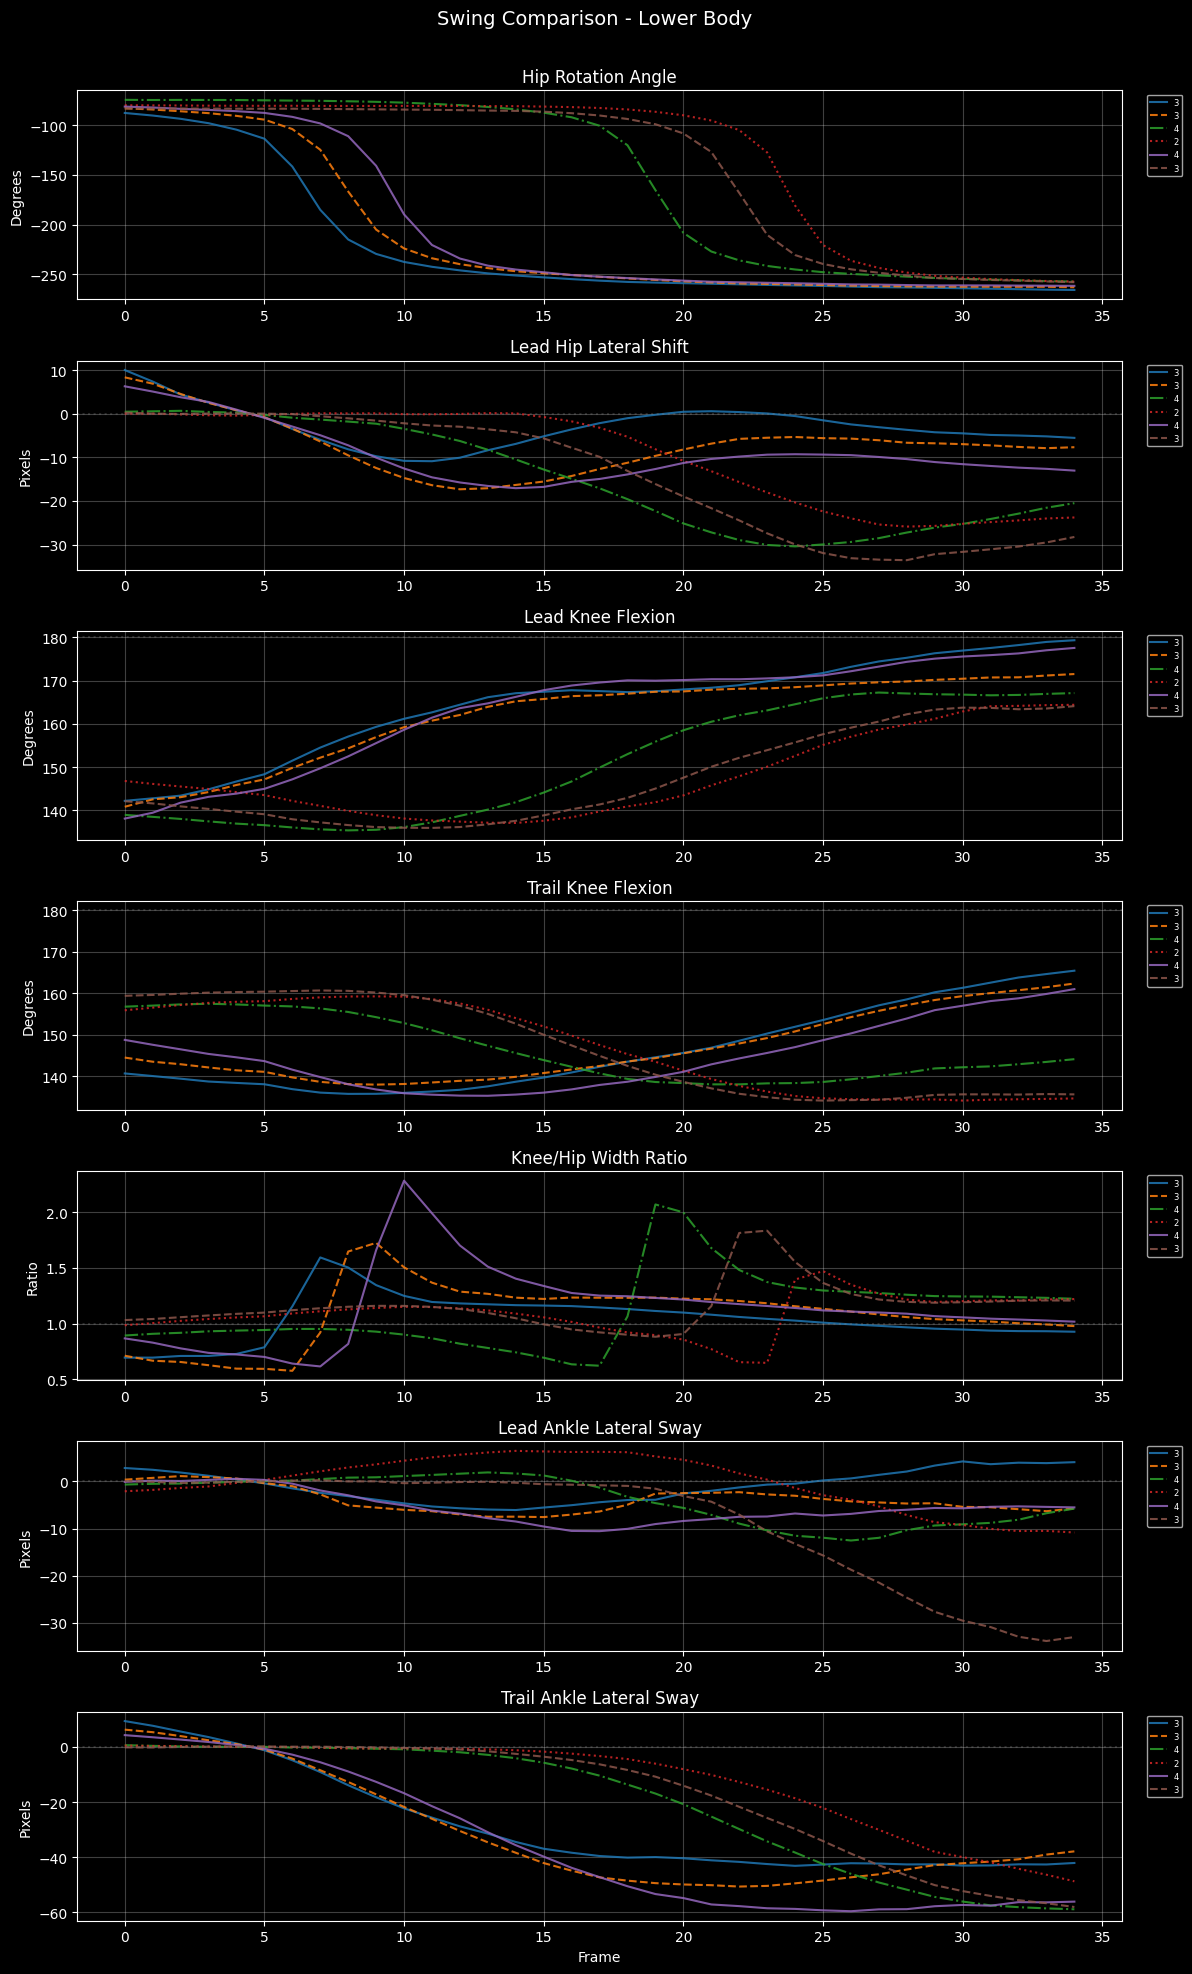

In [40]:
fig, axes = plot_lower_body_detailed(
    kps_list=[x[...,:2][10:45] for x in test_kps],
    scores_list=[x[...,2][10:45] for x in test_kps],
    labels=david_df.scores, #david_df.video_name.map(lambda x: x.split('.')[0]),
    params=PlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Swing Comparison - Lower Body"
)

In [42]:
from scipy.signal import savgol_filter


def get_derivative(np_array, axis=0, order=1):
    tns = torch.tensor(np_array).to('cuda')
    derivative = torch.diff(tns, axis=axis, n=order)
    np_derivative = derivative.cpu().numpy()
    return np_derivative



window_size = 21  # must be odd
poly_order = 3    # polynomial degree (typically 2-4)

def savgol_smooth(kps, window_size=10):
    window_len = window_size * 2 + 1
    smoothed = savgol_filter(kps, window_length=window_len, polyorder=3, axis=0)    
    return smoothed
#smoothed = savgol_filter(test_kps[0], window_length=21, polyorder=3, axis=0)
smooth_kps = [savgol_smooth(x) for x in test_kps]
first_order_smooth = [get_derivative(kps) for kps in smooth_kps]
second_order_smooth = [get_derivative(kps, order=2) for kps in smooth_kps]

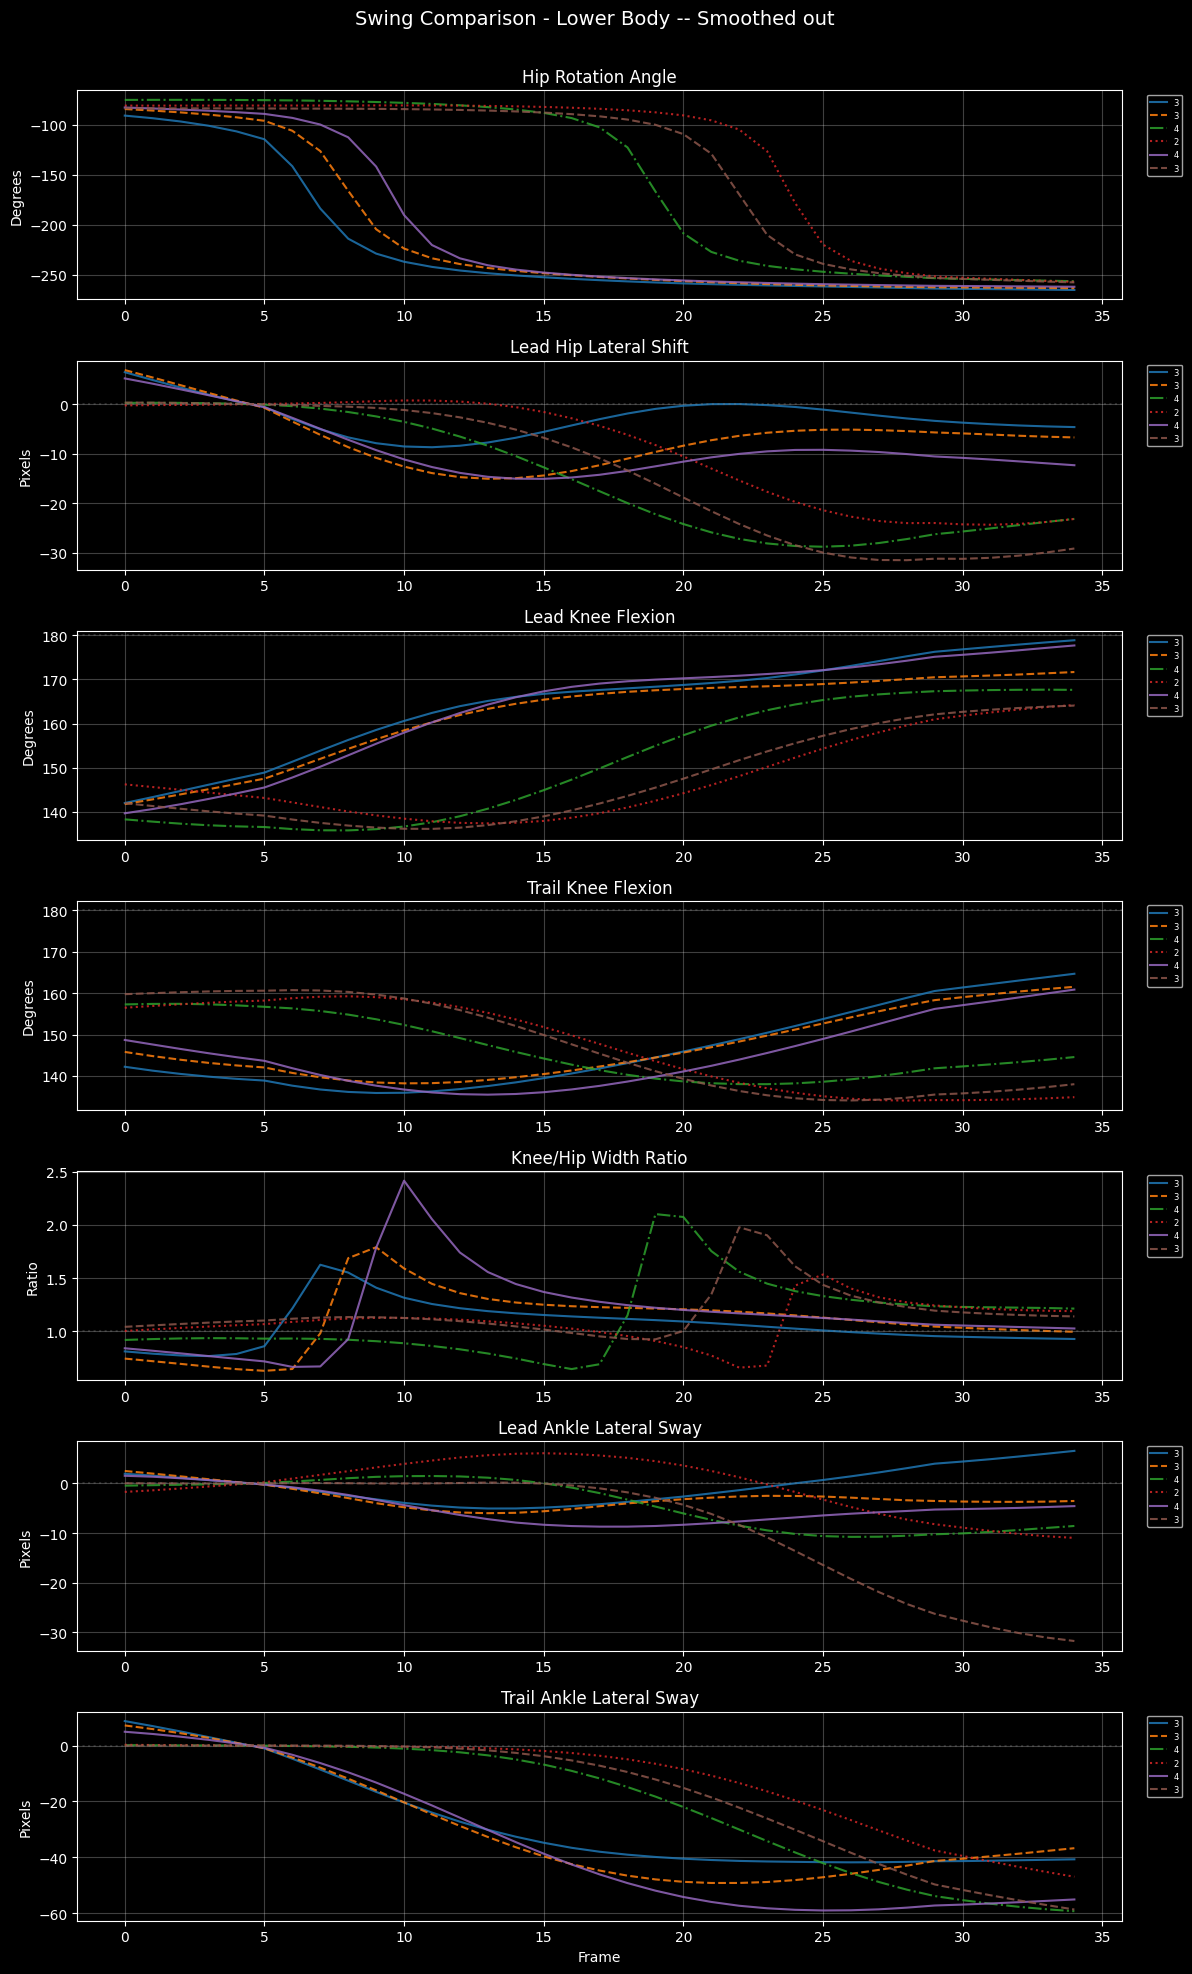

In [45]:
fig, axes = plot_lower_body_detailed(
    kps_list=[x[...,:2][10:45] for x in smooth_kps],
    scores_list=[x[...,2][10:45] for x in smooth_kps],
    labels=david_df.scores, #david_df.video_name.map(lambda x: x.split('.')[0]),
    params=PlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Swing Comparison - Lower Body -- Smoothed out"
)

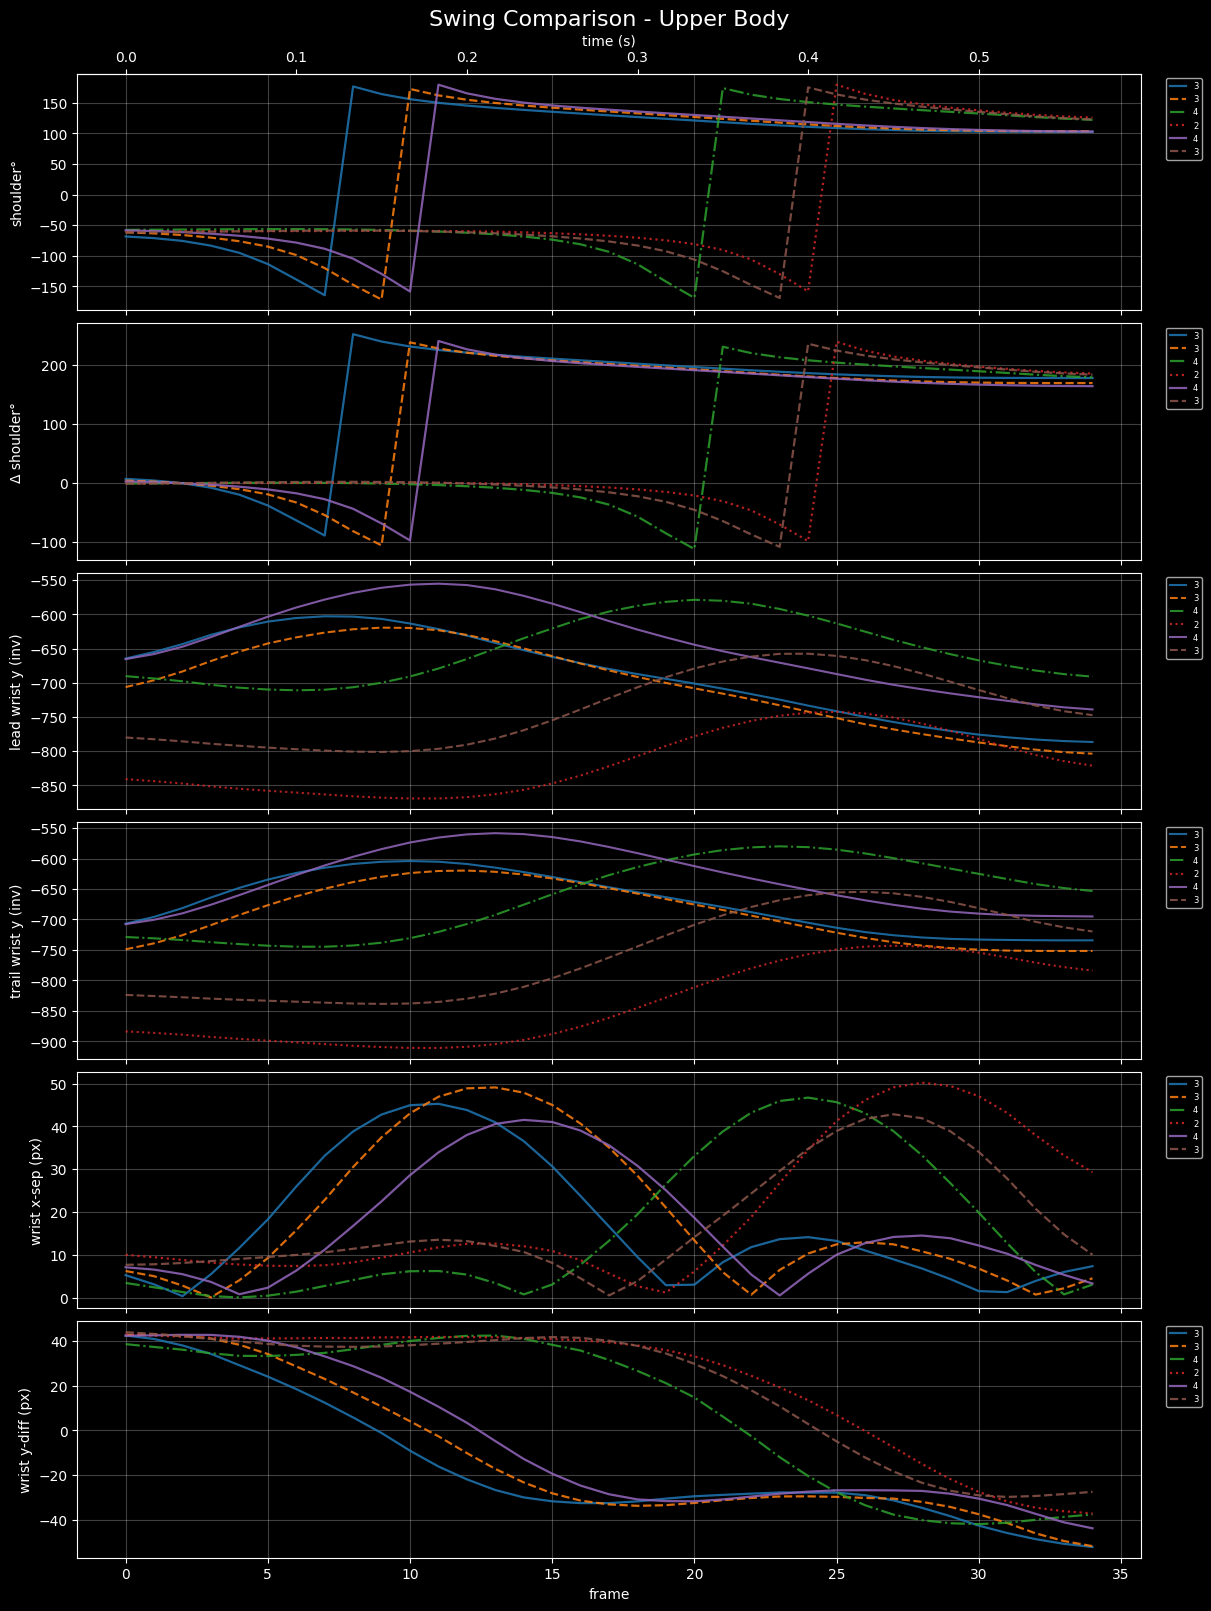

In [46]:
fig, axes = plot_upper_body_comparison(
    kps_list=[x[...,:2][10:45] for x in smooth_kps],
    scores_list=[x[...,2][10:45] for x in smooth_kps],
    labels=david_df.scores,
    params=UpperPlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Swing Comparison - Upper Body"
)